Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py


Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

For images, packages such as `Pillow`, `OpenCV` are useful
For audio, packages such as `scipy` and `librosa`
For text, either raw Python or Cython based loading, or `NLTK` and `SpaCy` are useful
Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the `CIFAR10` dataset. It has the classes: `‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’`. The images in `CIFAR-10` are of size `3x32x32`, i.e. 3-channel color images of 32x32 pixels in size.
![CIFAR-10](https://pytorch.org/tutorials/_images/cifar10.png)

## Training an image classifier
We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


## 1. Loading and normalizing `CIFAR10`

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range `[0, 1]`. We transform them to Tensors of normalized range `[-1, 1]`. .. note:

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [29]:
# Downloading the dataset
train_ds = torchvision.datasets.CIFAR10(root = './data/', train=True, download = True, transform=transform)
test_ds = torchvision.datasets.CIFAR10(root = './data/', train=False, download = True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [4]:
# Converting the dataset into a DataLoader
train_dl = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size= 8, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=False, batch_size= 8, num_workers=2)

## Data Visualizations

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8,1))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis(False)
    plt.show()
    
dataiter = iter(train_dl)
images, labels = dataiter.next()

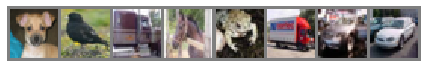

  dog  bird truck horse  frog truck   car   car


In [8]:
collage = torchvision.utils.make_grid(images)
imshow(collage)
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

# 2. Define a Convolutional Neural Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = Net()

# 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [21]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
epochs = 5

# 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [22]:
for epoch in range(epochs):         #One epoch runs over the whole image set
    running_loss = 0.0
    for i, data in enumerate(train_dl, start=0):
        xb, yb = data 
        optimizer.zero_grad()
        
        # Forward  + backward + optimize
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i%1000==999:
            print('[Epoch: %d, Batch: %5d] loss: %.3f' %(epoch, i+1, running_loss/1000))
            running_loss = 0.0
print('Finished Training :) ')
        
        
        

[Epoch: 0, Batch:  1000] loss: 2.144
[Epoch: 0, Batch:  2000] loss: 1.866
[Epoch: 0, Batch:  3000] loss: 1.685
[Epoch: 0, Batch:  4000] loss: 1.576
[Epoch: 0, Batch:  5000] loss: 1.497
[Epoch: 0, Batch:  6000] loss: 1.446
[Epoch: 1, Batch:  1000] loss: 1.387
[Epoch: 1, Batch:  2000] loss: 1.377
[Epoch: 1, Batch:  3000] loss: 1.365
[Epoch: 1, Batch:  4000] loss: 1.327
[Epoch: 1, Batch:  5000] loss: 1.295
[Epoch: 1, Batch:  6000] loss: 1.286
[Epoch: 2, Batch:  1000] loss: 1.247
[Epoch: 2, Batch:  2000] loss: 1.254
[Epoch: 2, Batch:  3000] loss: 1.239
[Epoch: 2, Batch:  4000] loss: 1.194
[Epoch: 2, Batch:  5000] loss: 1.212
[Epoch: 2, Batch:  6000] loss: 1.213
[Epoch: 3, Batch:  1000] loss: 1.194
[Epoch: 3, Batch:  2000] loss: 1.142
[Epoch: 3, Batch:  3000] loss: 1.169
[Epoch: 3, Batch:  4000] loss: 1.135
[Epoch: 3, Batch:  5000] loss: 1.167
[Epoch: 3, Batch:  6000] loss: 1.156
[Epoch: 4, Batch:  1000] loss: 1.121
[Epoch: 4, Batch:  2000] loss: 1.134
[Epoch: 4, Batch:  3000] loss: 1.122
[

let us save the model so that next time we can start from here. 

In [23]:
savepath = './cifar-stage1.pth'
torch.save(model.state_dict(), savepath)

In [26]:
12*1.852

22.224